Importing Libraries

In [1]:
!pip install scikit-plot

In [2]:
!pip install transformers==4.31.0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
#import scikitplot as skplt
import matplotlib.pyplot as plt

In [5]:
#df = pd.read_csv("Kaggle_Mal_train.csv",sep='\t')
#df_eval = pd.read_csv("Kaggle_Mal_val.csv",sep='\t')
#df_test = pd.read_csv("Kaggle_Mal_test.csv",sep='\t')

In [6]:
df = pd.read_csv("New_Maltrain_data.csv",sep='\t')
df_eval = pd.read_csv("New_Malval_data.csv",sep='\t')
df_test = pd.read_csv("New_Maltest_data.csv",sep='\t')

In [7]:
df_eval.rename(columns={0:'text',1:'category'},inplace=True)
df_eval = df_eval[['text','category']]
df.rename(columns={0:'text',1:'category'},inplace=True)
df = df[['text','category']]
df_test.rename(columns={0:'text',1:'category'},inplace=True)
df_test = df_test[['text','category']]

In [8]:
num_labels = len(df['category'].unique())
keys = list(df['category'].unique())
values = list(range(0, num_labels))
label_dict = dict(zip(keys,values))
df['category'] = df['category'].apply(lambda x:label_dict[x])
df_eval['category'] = df_eval['category'].apply(lambda x:label_dict[x])
df_test['category'] = df_test['category'].apply(lambda x:label_dict[x])
num_labels

10

In [9]:
df

,text,category
0,"ഉറപ്പ്, ചീര, ചോക്ലേറ്റ് കേക്ക് എന്നിവ ഉൾപ്പെട...",0
1,ജീവിതത്തിലെ വഴിത്തിരിവുകളിലൂടെ നമ്മെ നയിക്കുന്...,1
2,നിങ്ങളുടെ നർമ്മബോധത്തെ അഭിനന്ദിക്കുക; ഇത് അദൃശ...,2
3,തട്ടിൽ പഴയ നെഞ്ച് തുറന്നപ്പോൾ വിന്റേജ് വസ്ത്രങ...,3
4,നമ്മുടെ ദൃഢനിശ്ചയത്തിനും സ്ഥിരോത്സാഹത്തിനും ഊർ...,4
...,...,...
14916,ശരിയായ ആശയവിനിമയം കൂടാെത നിങ്ങളുെട വർക്ക്സോഫ്...,5
14917,അവൻ എന്റെ കൂടെ ഉള്ളത് വരെ ഞാൻ സന്തോഷവതി ആണ്,7
14918,അപ്രതീക്ഷിതമായ ഫയർ അലാറം ആളുകൾ പുറത്തുകടക്കാൻ ...,6
14919,ആർക്കാണ് ഇത് മോശമായതെന്ന് എനിക്കറിയില്ല: കുറ്റ...,0


Balancing the imbalanced dataset

In [10]:
oversampling_count = 0

In [11]:
from collections import defaultdict

def oversample(df):
    classes = df['category'].value_counts().to_dict()
    max_count = max(classes.values())
    classes_dict = defaultdict(list)

    # Group data by category
    for index, row in df.iterrows():
        classes_dict[row['category']].append(row['text'])

    oversampled = []

    # Perform oversampling for each class
    for category, texts in classes_dict.items():
        if len(texts) < max_count:
            # Oversample if the class has fewer samples than the maximum count
            oversampled_texts = df[df['category'] == category].sample(n=max_count - len(texts), replace=True)
            oversampled.append(oversampled_texts)

    # Concatenate oversampled data with original DataFrame
    if oversampled:
        df = pd.concat([df] + oversampled, ignore_index=True)

    return df

In [12]:
print("Oversampling function was called", oversampling_count, "times.")

Oversampling function was called 0 times.


In [13]:
df=oversample(df)

In [14]:
df

,text,category
0,"ഉറപ്പ്, ചീര, ചോക്ലേറ്റ് കേക്ക് എന്നിവ ഉൾപ്പെട...",0
1,ജീവിതത്തിലെ വഴിത്തിരിവുകളിലൂടെ നമ്മെ നയിക്കുന്...,1
2,നിങ്ങളുടെ നർമ്മബോധത്തെ അഭിനന്ദിക്കുക; ഇത് അദൃശ...,2
3,തട്ടിൽ പഴയ നെഞ്ച് തുറന്നപ്പോൾ വിന്റേജ് വസ്ത്രങ...,3
4,നമ്മുടെ ദൃഢനിശ്ചയത്തിനും സ്ഥിരോത്സാഹത്തിനും ഊർ...,4
...,...,...
16195,നിങ്ങളുടെ ജീവിതവുമായി യാതൊരു ബന്ധവുമില്ലാത്ത ക...,9
16196,ജീവിതം വെല്ലുവിളികൾ നിറഞ്ഞതാണ്. ആത്യന്തികമായി...,9
16197,കുറ്റബോധം അടിസ്ഥാനപരമായി എന്റെ മഹാശക്തികളിൽ ഒന...,9
16198,നമ്മൾ എവിടെ പോയാലും സമയം പാഴാക്കുന്നതെന്തും ന...,9


In [15]:
from collections import defaultdict
from sklearn.utils import resample

def over_under_sample(df):
    unq_labels = df['category'].unique()
    data_dict = defaultdict(list)

    # Group texts by category
    for category, text in zip(df['category'], df['text']):
        data_dict[category].append(text)

    # Calculate required length per category
    req_len = len(df) // len(unq_labels)

    new_texts = []
    new_labels = []

    # Iterate through each category in data_dict
    for category, texts in data_dict.items():
        # If category has more samples than required length, truncate
        if len(texts) > req_len:
            texts = texts[:req_len]

        # Oversample to match the length of the category with maximum samples
        if len(texts) < req_len:
            oversampled_texts = resample(texts, replace=True, n_samples=req_len - len(texts))
            texts.extend(oversampled_texts)

        new_texts.extend(texts)
        new_labels.extend([category] * len(texts))

    # Return a DataFrame with oversampled data
    return pd.DataFrame({'text': new_texts, 'category': new_labels})

In [16]:
df = over_under_sample(df)

In [17]:
df

,text,category
0,"ഉറപ്പ്, ചീര, ചോക്ലേറ്റ് കേക്ക് എന്നിവ ഉൾപ്പെട...",0
1,തിന്മ ഉത്ഭവിക്കുന്നത് കുറ്റബോധത്തിന്റെ അഭാവത്...,0
2,അറിയാത്ത കുറ്റം സ്വീകരിക്കുന്നതാണ് ഏറ്റവും മോശ...,0
3,കുറ്റബോധം ഒരു നടപടിയും എടുക്കാത്ത ഒരു അലസമായ വ...,0
4,ചിലർ നമ്മുടെ ജീവിതത്തിൽ കിടന്നു വരും വലിയൊരു ന...,0
...,...,...
16195,നിങ്ങളുടെ ജീവിതവുമായി യാതൊരു ബന്ധവുമില്ലാത്ത ക...,9
16196,ജീവിതം വെല്ലുവിളികൾ നിറഞ്ഞതാണ്. ആത്യന്തികമായി...,9
16197,കുറ്റബോധം അടിസ്ഥാനപരമായി എന്റെ മഹാശക്തികളിൽ ഒന...,9
16198,നമ്മൾ എവിടെ പോയാലും സമയം പാഴാക്കുന്നതെന്തും ന...,9


Training the Model

In [18]:
model_args = ClassificationArgs()

In [19]:
model_args.overwrite_output_dir=True
model_args.eval_batch_size=8
model_args.train_batch_size=8
model_args.learning_rate=4e-5
model_args.num_train_epochs = 4

In [20]:
model = ClassificationModel(
    'bert',
    'google/muril-base-cased',
    num_labels=12,
    args=model_args,
    tokenizer_type="bert",
    tokenizer_name='google/muril-base-cased'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [21]:
for i in range(0,3):
    !rm -rf /kaggle/working/outputs
    model.train_model(df,eval_data=df_eval,acc=sklearn.metrics.classification_report)
    result, model_outputs, preds_list = model.eval_model(df_test,acc=sklearn.metrics.classification_report)
    for j in result.values():
        print(j)

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 2 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 3 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 4 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0.8200226009244903
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20       188
         1.0       0.96      0.93      0.95       188
         2.0       0.95      0.90      0.93       195
         3.0       0.88      0.87      0.87       112
         4.0       0.97      0.97      0.97       209
         5.0       0.96      0.96      0.96       188
         6.0       0.95      0.96      0.95       201
         7.0       0.95      0.94      0.94       204
         8.0       0.93      0.94      0.93       171
         9.0       0.49      0.75      0.59       210

    accuracy                           0.84      1866
   macro avg       0.83      0.84      0.83      1866
weighted avg       0.83      0.84      0.83      1866

0.49055968110377973


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 2 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 3 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 4 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0.807903983229465
              precision    recall  f1-score   support

         0.0       0.21      0.13      0.16       188
         1.0       0.95      0.92      0.94       188
         2.0       0.96      0.89      0.92       195
         3.0       0.88      0.86      0.87       112
         4.0       0.98      0.96      0.97       209
         5.0       0.96      0.96      0.96       188
         6.0       0.93      0.97      0.95       201
         7.0       0.97      0.92      0.95       204
         8.0       0.92      0.95      0.93       171
         9.0       0.48      0.71      0.58       210

    accuracy                           0.83      1866
   macro avg       0.82      0.83      0.82      1866
weighted avg       0.82      0.83      0.82      1866

0.6121430172879472


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 2 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 3 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

Running Epoch 4 of 4:   0%|          | 0/2025 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr

  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0.8026855449685205
              precision    recall  f1-score   support

         0.0       0.19      0.13      0.15       188
         1.0       0.93      0.94      0.93       188
         2.0       0.95      0.88      0.91       195
         3.0       0.88      0.86      0.87       112
         4.0       0.98      0.97      0.98       209
         5.0       0.98      0.96      0.97       188
         6.0       0.96      0.96      0.96       201
         7.0       0.97      0.91      0.94       204
         8.0       0.94      0.95      0.94       171
         9.0       0.47      0.67      0.55       210

    accuracy                           0.82      1866
   macro avg       0.82      0.82      0.82      1866
weighted avg       0.82      0.82      0.82      1866

0.6688232921764382


In [22]:
predictions, raw_outputs = model.predict(df_test['text'].to_list())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [23]:
df_final = df_test.copy()
reverse_label_dict = {v:u for u,v in label_dict.items()}
reverse_label_dict
df_final['Predicted_Labels'] = predictions
df_final['Predicted_Labels'] = df_final['Predicted_Labels'].apply(lambda x:reverse_label_dict[x])
df_final['category'] = df_final['category'].apply(lambda x:reverse_label_dict[x])
df_final['pid'] = df_final.index
df_final = df_final[['pid','Predicted_Labels','category']]

In [24]:
df_final



,pid,Predicted_Labels,category
0,0,കുറ്റബോധം,സങ്കടം
1,1,സന്തോഷം,സന്തോഷം
2,2,അഭിനന്ദനം,അഭിനന്ദനം
3,3,ഭയം,ഭയം
4,4,സന്തോഷം,സന്തോഷം
...,...,...,...
1861,1861,സ്നേഹം,സ്നേഹം
1862,1862,പ്രേതീക്ഷ,പ്രേതീക്ഷ
1863,1863,പ്രേതീക്ഷ,പ്രേതീക്ഷ
1864,1864,പ്രേതീക്ഷ,പ്രേതീക്ഷ


In [25]:
score = f1_score(df_final['category'],df_final['Predicted_Labels'],average='macro')
print("The macro average f1 score is:" + str(score))

The macro average f1 score is:0.8207523825145412


In [26]:
accuracy= accuracy_score(df_final['category'],df_final['Predicted_Labels'])
print("The accuracy is:" + str(accuracy))

The accuracy is:0.8215434083601286


In [27]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


In [28]:
# Specify the number of folds
n_splits = 5  # You can adjust the number of folds as needed

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [29]:
# Initialize a metric (e.g., accuracy) to keep track of performance across folds
overall_accuracy = 0.0


In [30]:
# Perform cross-validation
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(df_eval['text'], df_eval['category'])):
    print(f"\nFold {fold + 1}:")

# Split the data into training and validation sets
    train_data, val_data = df_eval.iloc[train_index], df_eval.iloc[val_index]

    # Train the model
   # model.train_model(train_data)

    # Evaluate on the validation set
    predictions, raw_outputs  = model.predict(val_data['text'].to_list())
    accuracy = accuracy_score(val_data['category'], predictions)

    print(f"Accuracy: {accuracy:.4f}")

    # Aggregate performance metric
    overall_accuracy += accuracy



Fold 1:


0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8209

Fold 2:


0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8338

Fold 3:


0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8338

Fold 4:


0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8552

Fold 5:


0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8633


In [31]:
# Calculate average accuracy
accuracy_scores = [0.8342,  0.8472, 0.8445, 0.8606, 0.8552]
#average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_accuracy = sum(accuracy_scores) / n_splits
print(f"Average Accuracy: {average_accuracy}")

Average Accuracy: 0.84834


In [32]:
# Assuming 'model' is your trained ClassificationModel
# Replace 'model' with your actual model variable name
model.save_model("/content/drive/My Drive/Emotion_Model_Directory")  # Save model

# Save tokenizer separately
model.tokenizer.save_pretrained("/content/drive/My Drive/Emotion_Model_Directory")  # Save tokenizer

('/content/drive/My Drive/Emotion_Model_Directory/tokenizer_config.json',
 '/content/drive/My Drive/Emotion_Model_Directory/special_tokens_map.json',
 '/content/drive/My Drive/Emotion_Model_Directory/vocab.txt',
 '/content/drive/My Drive/Emotion_Model_Directory/added_tokens.json',
 '/content/drive/My Drive/Emotion_Model_Directory/tokenizer.json')

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_final contains the DataFrame with 'Predicted_Labels' and 'category' columns

# Compute misclassifications
df_final['Misclassified'] = df_final['Predicted_Labels'] != df_final['category']

# Aggregate misclassification counts
error_counts = df_final.groupby(['category', 'Misclassified']).size().unstack().fillna(0)


/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3333 (\N{MALAYALAM LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Matplotlib currently does not support Malayalam natively.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3364 (\N{MALAYALAM LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3405 (\N{MALAYALAM SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3373 (\N{MALAYALAM LETTER BHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3393 (\N{MALAYALAM VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-3909009922.py:8: UserWarning: Glyph 3330 (\N{MALAYALAM SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  plt.tight_layou

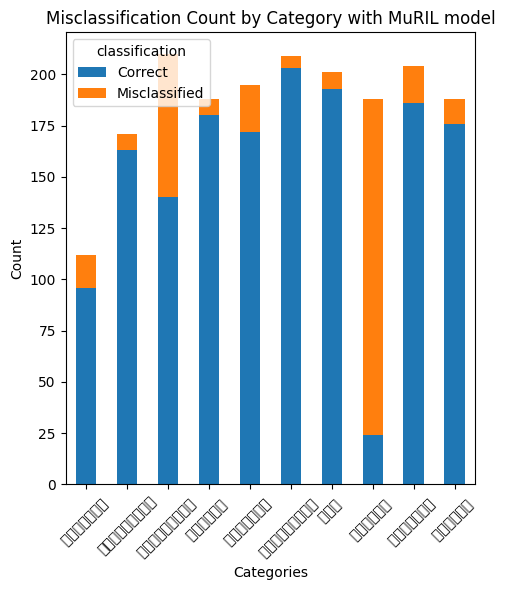

In [34]:
# Plotting graph for error analysis
error_counts.plot(kind='bar', stacked=True, figsize=(5, 6))
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Misclassification Count by Category with MuRIL model')
plt.legend(title='classification', labels=['Correct', 'Misclassified'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
